<a href="https://colab.research.google.com/github/yooburi/ML_DL_yooburi/blob/main/machine_ai_applications/midterm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Problem

## 분류(Classification) 개념

- **목표**: 주어진 입력을 여러 **범주(class)** 중 하나로 할당
- 예: 이메일 → 스팸/정상, 이미지 → 고양이/개, 환자 데이터 → 질병 여부
- **회귀 vs 분류**
    - 회귀: 연속 값 예측 (예: 집값)
    - 분류: 이산 클래스 예측 (예: 강아지/고양이)
- 출력층 활성화 함수
    - 다중 클래스: Softmax → 각 클래스 확률
    - 이진 분류: Sigmoid → 양성 클래스 확률

---

##이진 분류(Binary Classification)

이진 분류를 위해서는 출력층에 0~1을 만족하는 함수가 필요하며, sigmoid 함수를 이용해 이를 구현한다.

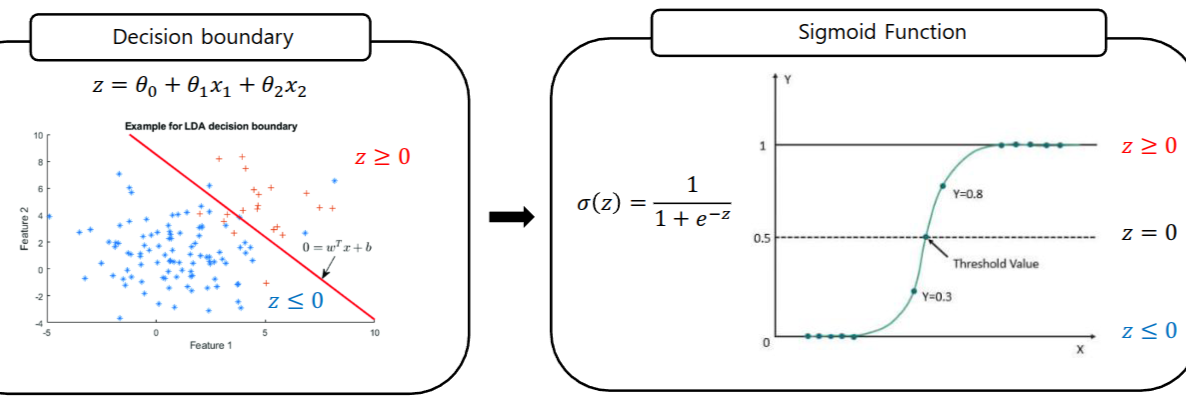

z는 입력변수와 가중치의 선형결합으로 결정 경계(Decision boundary)를 결정하는 역할을 한다.

이 경계를 기준으로 sigmoid 함수에 입력해 0~1 사이의 값으로 분류하게 된다.

---

### 데이터 준비: make_moons
- 2D 데이터로 시각화와 결정 경계(decision boundary) 관찰
- 학습/테스트 데이터 분리



In [ ]:
import torch
from sklearn.datasets import make_moons #데이터셋
from sklearn.model_selection import train_test_split #
import matplotlib.pyplot as plt

# make moon 함수를 이용해 반달 모양의 500개의 좌표 데이터 생성
# 반달 형태의 이진분류 데이터 500개 생성.(노이즈로 난이도 약각 up, 시드 고정으로 재현성)
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

# 학습 70% , 테스트 30%로 분리 + 재현성 고정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 시각화
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', s=10)
plt.title('Train data')
plt.show()

# 텐서 변환
# torch는 tensor 연산 지원.
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long) # 정수형
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long) # 정수형


> 왜 텐서로 변환할까??

```
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)
```
> pytorch 모델은 numpy 배열이 아니라 torch.Tensor를 입력으로 받아서 계산한다. torch.Tensor는 GPU에서 연산 가능한 데이터 구조. 자동 미분 기능을 지원하고 cuda GPU 연산을 지원한다. 즉, 딥러닝 연산을 위해 최적화된 데이터 형태.

> nn.Linear, nn.ReLU, nn.CrossEntropyLoss 같은 PyTorch 모듈은 모두 입력으로 Tensor 타입만 처리함.

###인공지능 모델 설정 Multi Layer Perceptron

- 은닉층: 2개, ReLU 활성화 함수 사용
- 출력층: 클래스 수만큼 노드, sigmoid 활성화 함수  사용

In [ ]:
import torch.nn as nn

# nn.Module 상속한 다층퍼셉트론 클래스
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim)
    )

  # 순전파
  # 분류라면 마지막에 softmax 넣지 않는다 -> CrossEntropyLoss가 내부에서 처리
  def forward(self, x):
    return self.net(x)

model = MLP(2,16,2)
print(model)

입력층(2) → 은닉층1(16) → 은닉층2(16) → 출력층(2)

가중치 파라미터의 개수
: 2×16+16×16+16×2+(16+16+2)=354

### 학습
- 손실 함수: CrossEntropyLoss (softmax+NLLLoss)
- 옵티마이저: Adam
- 에폭 수, 배치 학습

> What is CrossEntropyLoss?


In [ ]:
# 모델 출력 vs 정답으로 분류 손실 계산 -> 마지막에 softmax 필요 없음
criterion = nn.CrossEntropyLoss()
# 가중치 업데이트 규칙(adam), 학습률 지정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
batch_size = 32

# 데이터 로더 준비
# (입력, 라벨) 튜플로 묶음 -> 미니배치로 섞어서 공급
dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_hist = []
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad() #이전 step 기울기 초기화
        pred = model(xb) #순전파 -> predict value 출력
        loss = criterion(pred, yb) #배치 손실 계산
        loss.backward() #역전파 -> 기울기 계산
        optimizer.step() #가중치 업데이트
        total_loss += loss.item()*len(xb) #배치 손실을 샘플 수로 가중합해 에포크 평균 손실 준비

    loss_hist.append(total_loss/len(dataset)) #에포크 평균 손실 기록
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss={loss_hist[-1]:.4f}')

plt.figure()
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 평가 및 정확도 & 결정 경계 시각화

In [ ]:
# 평가 및 정확도
with torch.no_grad(): #평가 시 기울기 계산 비활성화(메모리, 속도 이점)
    pred_test = model(X_test_t) #pred value by test dataset
    y_pred_cls = pred_test.argmax(dim=1)
    acc = (y_pred_cls == y_test_t).float().mean().item()
print(f'Test Accuracy: {acc*100:.2f}%')


# 결정 경계 시각화
import numpy as np
h = 0.02
x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


# 반복된 선형결합의 결과를 나타낸 값. -> 클래스 예측 맵
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', s=10)
plt.title('Decision Boundary (Test data)')
plt.show()

## 다중 분류

### 3개의 분류값을 가지는 다중분류 -> 출력층에서 softmax 활용
모든 라벨의 총합을 100%로 두어 확률을 계산하는 softmax가 활용

### 데이터 준비: make_blobs

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# 데이터 생성: 2D 좌표, 3개 클래스
X, y = make_blobs(
    n_samples=600,       # 전체 데이터 수
    centers=3,           # 클래스 개수
    n_features=2,        # 좌표 차원
    cluster_std=5.0,     # ↑ 표준편차 키우면 경계가 흐릿해짐
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='tab10', s=10)
plt.title('Train data (3 classes)')
plt.show()

# 텐서 변환
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)



### 모델 설정 & 학습

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 3)
)

print(model)

입력층(2) → 은닉층1(32) → 은닉층2(32) → 출력층(3)

가중치 파라미터의 개수
: 2×32+32×32+32×3+(32+32+3)= 1251

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

batch_size = 32
dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습
epochs = 200
loss_hist = []
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb) #예측          # (B, 3)
        loss = criterion(logits, yb)     # yb: (B,), 0/1/2
        loss.backward() #역전파
        optimizer.step()
        total_loss += loss.item() * len(xb)
    loss_hist.append(total_loss / len(dataset))
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss={loss_hist[-1]:.4f}')

plt.figure()
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 테스트 정확도
with torch.no_grad():
    logits_test = model(X_test_t)
    y_pred_cls  = logits_test.argmax(dim=1)
    acc = (y_pred_cls == y_test_t).float().mean().item()
print(f'Test Accuracy: {acc*100:.2f}%')


# 결정 경계 시각화 (3색)
h = 0.02
x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='tab10', alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', s=12, edgecolor='k', linewidth=0.2)
plt.title('Decision Boundary (3-class, Test data)')
plt.show()

### Problem & 생각해볼만한 Solution

epoch가 100에서는 Loss가 수렴되고 있지 않은 것을 볼 수 있다.

**좋은 학습데이터가 성능을 만든다.** 현재 scatter을 보면 표준편차가 큰 탓에 정확하게 분류하기 힘든 것으로 보인다. + 표준편차를 줄이니 학습 성능이 향상된 것을 볼 수 있다.


표준편차를 유지하고 정규화를 한번해서 scale을 줄여볼까? -> 똑같다.


In [ ]:
from sklearn.preprocessing import StandardScaler

# 스케일링 (train 통계로 fit → train/test 변환)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)  # train으로만 fit
X_test_std  = scaler.transform(X_test)

# 시각화(표준화된 공간)
plt.figure()
plt.scatter(X_train_std[:,0], X_train_std[:,1], c=y_train, cmap='tab10', s=10)
plt.title('Train data (Standardized)')
plt.show()

# 텐서 갱신
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train,    dtype=torch.long)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test,     dtype=torch.long)



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

batch_size = 32
dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습
epochs = 100
loss_hist = []
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb) #예측          # (B, 3)
        loss = criterion(logits, yb)     # yb: (B,), 0/1/2
        loss.backward() #역전파
        optimizer.step()
        total_loss += loss.item() * len(xb)
    loss_hist.append(total_loss / len(dataset))
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss={loss_hist[-1]:.4f}')

plt.figure()
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 테스트 정확도
with torch.no_grad():
    logits_test = model(X_test_t)
    y_pred_cls  = logits_test.argmax(dim=1)
    acc = (y_pred_cls == y_test_t).float().mean().item()
print(f'Test Accuracy: {acc*100:.2f}%')


# 결정 경계 시각화 (3색)
h = 0.02
x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='tab10', alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', s=12, edgecolor='k', linewidth=0.2)
plt.title('Decision Boundary (3-class, Test data)')
plt.show()

## CNN 활용 다중 분류
- python에서 제공하는 MNIST 데이터셋을 활용한 숫자 분류


### 데이터 준비

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 데이터 준비: Tensor 변환(+ 간단 표준화) → DataLoader
# 이미지를 [0,1] 범위의 torch.Tensor로 변환
transform = transforms.Compose([
    transforms.ToTensor(),                            # [0,1] 텐서
    #MNIST(grayscale 1채널)의 채널별 평균/표준편차로 표준화
    transforms.Normalize((0.1307,), (0.3081,)),       # MNIST 평균/표준편차

])

# 변환을 적용한 학습, 테스트 데이터셋 준비
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# 미니배치로 섞어서 공급. train 데이터는 shuffle
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

### CNN 모델 설정

Conv → ReLU → MaxPool ×2 → Flatten → Full Connected → ReLU → Full Connected



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), # Bx32x28x28
    nn.MaxPool2d(2),  # 28x28 -> 14x14
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), # Bx64x14x14
    nn.MaxPool2d(2),  # 14x14 -> 7x7
    nn.Flatten(),     # 64*7*7 = 3136
    nn.Linear(64*7*7, 128), nn.ReLU(), #3128 -> 128 -> 10 Full connected
    nn.Linear(128, 10)   # 10개 클래스(logits)
)

print(model)

### 학습

In [ ]:
criterion = nn.CrossEntropyLoss()               # 소프트맥스 내장됨
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 학습 loop
EPOCHS = 3
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        # 순전파
        logits = model(xb)
        loss = criterion(logits, yb)

        # 역전파 + 갱신
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total * 100
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss {train_loss:.4f} | Train Acc {train_acc:.2f}%")


In [ ]:
#테스트 및 평가
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# 예시 시각화(테스트 샘플 8개와 예측 라벨)
import numpy as np
images, labels = next(iter(test_loader))
with torch.no_grad():
    preds = model(images).argmax(dim=1)

plt.figure(figsize=(10,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i,0].numpy(), cmap="gray")
    plt.title(f"pred: {preds[i].item()} / true: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

---

## 실습과제: 4개 클래스 분류

1. 앞선 다중분류 모델에서 centers=4로 설정하고 4개의 분류값을 가지는 다중분류 모델을 만드시오.

2. 정확도를 높이기 위한 방법을 고민하고, 개선 모델을 함께 제출하시오.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
# 표준화 -> 스케일링
from sklearn.preprocessing import StandardScaler


# 데이터 생성: 2D 좌표, 4개 클래스
X, y = make_blobs(
    n_samples=600,       # 전체 데이터 수
    centers=4,           # 클래스 개수
    n_features=2,        # 좌표 차원
    cluster_std=5.0,     # ↑ 표준편차 키우면 경계가 흐릿해짐
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='tab10', s=10)
plt.title('Train data (4 classes)')
plt.show()

#표준화 (train 통계로만)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train,    dtype=torch.long)
X_test_t  = torch.tensor(X_test_s,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test,     dtype=torch.long)

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 4)
)

print(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 128
dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습
epochs = 200
loss_hist = []
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb) #예측          # (B, 4)
        loss = criterion(logits, yb)     # yb: (B,), 0/1/2
        loss.backward() #역전파
        optimizer.step()
        total_loss += loss.item() * len(xb)
    loss_hist.append(total_loss / len(dataset))
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss={loss_hist[-1]:.4f}')

plt.figure()
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 테스트 정확도
with torch.no_grad():
    logits_test = model(X_test_t)
    y_pred_cls  = logits_test.argmax(dim=1)
    acc = (y_pred_cls == y_test_t).float().mean().item()
print(f'Test Accuracy: {acc*100:.2f}%')


# 결정 경계 시각화 (3색)
h = 0.02
x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy()
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='tab10', alpha=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', s=12, edgecolor='k', linewidth=0.2)
plt.title('Decision Boundary (4-class, Test data)')
plt.show()

기본 코드에서

1. 은닉층의 개수를 하나 더 늘리고 각 은닉층의 뉴련의 개수를 128개로 늘렸습니다.



2. Loss가 높아도 수렴하는 것에 집중하여 파라미터를 조정하였습니다. 학습률은 기존 0.01에서 0.001로 batch_size는 32에서 128로 수정해주었고 Loss가 수렴하는 것을 확인하였습니다.



3. 해당 파라미터들이 랜덤하게 섞여 있는 데이터 셋에 과적합되지 않고 단순하다는 생각을 하여 현재 데이터셋에서 가장 최적의 파라미터라고 생각하였습니다.

